### Using Stemming and Lemmatizing 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split    
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
import nltk
from nltk import word_tokenize


In [2]:
# create data frame
data = pd.read_csv("../data/bag_of_words.csv", delimiter = ',')

In [3]:
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [11]:
# import Lemmatization
from nltk.stem import WordNetLemmatizer

# create an object of class WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

print(lemmatizer.lemmatize("feet"))


foot


In [12]:
# preprocess the data to remove unwanted numerical values and special characters
import re
import string

# first remove the tags
def no_tags(text):
    text = re.sub('<[^<]+?>', '', text)
    return text

# create regexptokenizer
from nltk.tokenize import RegexpTokenizer
# Define the custom tokenizer pattern 
pattern = r'\d+\s*out\s*of\s*\d+|\d+\s*stars?|[a-zA-Z]{2,}' 
# Initialize the RegexpTokenizer with the custom pattern 
custom_tokenizer = RegexpTokenizer(pattern)


In [14]:
# clean our data
df = data.copy()

data['review'] = data['review'].apply(no_tags)

In [15]:
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [16]:
# tokenize with custom regexptokenizer
def tokenize(text):
    return custom_tokenizer.tokenize(text)

data['review'] = data['review'].apply(tokenize)

In [17]:
data.head()

,id,sentiment,review
0,5814_8,1,"[With, all, this, stuff, going, down, at, the,..."
1,2381_9,1,"[The, Classic, War, of, the, Worlds, by, Timot..."
2,7759_3,0,"[The, film, starts, with, manager, Nicholas, B..."
3,3630_4,0,"[It, must, be, assumed, that, those, who, prai..."
4,9495_8,1,"[Superbly, trashy, and, wondrously, unpretenti..."


Before using **.lemmatize** which will lemmatize our words we need a function that will map each word to the correct part of speach. This is because wordnet lemmatizer will treat all words as a noun by default which will not give us the best results.
+ **nltk.pos_tag** will return the part of speech for the given word. We will add the list of words here so it will go through and grab each part of speach. 
+ we use [0][1][0].upper() since the **nltk.pos_tag** will return a list of tuples that includes each word and the part of speech. So [0][1] will grab the part of speech for the given token. The [0].upper() will then make the part of speech capital. They are converted to upper so that we can map them to the word net part of speech using a dictionary. We return the tag and if the word is not found we will treat it as a noun. 

In [21]:
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger_eng')  # used for tagging the part of speech for words
# Function to get the WordNet POS tag 
def get_wordnet_pos(word): 
    tag = nltk.pos_tag([word])[0][1][0].upper() 
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN, 
                "V": wordnet.VERB, 
                "R": wordnet.ADV} 
    return tag_dict.get(tag, wordnet.NOUN)

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\ryans\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.


In [22]:
# lemmatize using list comprehension
def lemmatize(tokens):
    return [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in tokens]

In [23]:
# apply the function to the tokenized column
data['review'] = data['review'].apply(lemmatize)


In [ ]:
# join the tokens so that we can use CountVectorizer since they expect strings
data['review'] = data['review'].apply(lambda x: ' '.join(x))

In [28]:
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff go down at the moment with...
1,2381_9,1,The Classic War of the Worlds by Timothy Hines...
2,7759_3,0,The film start with manager Nicholas Bell give...
3,3630_4,0,It must be assume that those who praise this f...
4,9495_8,1,Superbly trashy and wondrously unpretentious e...


In [29]:
from sklearn.feature_extraction.text import CountVectorizer
# create CountVectorizer using the stopwords and default tokenizer
count_vect = CountVectorizer(stop_words = 'english')

# fit our data to the CountVectorizer
our_count_vect = count_vect.fit_transform(data['review'])


In [30]:
# import the TfidfTransformer from sklearn.feature_extraction.text
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit_transform(our_count_vect)

In [31]:
# create X and y split
X_train, X_test, y_train, y_test = train_test_split(tfidf_transformer, data['sentiment'], test_size = 0.2, random_state = 42)

# logistic regression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

# predictions
predicted = log_reg.predict(X_test)


This model did not perform better than our model when we did not use lemmatization. This is just something we have to try to  see if we are getting better results or not. With lemmatization we may have lost some information from the context of the words we changed. 

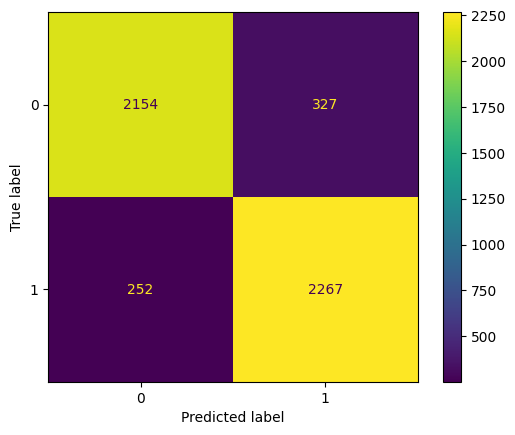

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test)

#### Lexicon

We can try using a **lexicon** for our analysis as well. Below we use the lexicon **afinn** which is a list of words that have been rated between -5 and +5 for sentiment scores. When we use this lexicon on our data it will tokenize the review on a word-level then sum up the values for all words in the review for a total score. This seems like a great way to perform our sentiment analysis but as we see below, the results are not good. Just looking at the head of our data we see that the first sentiment score is -17 which tells us this is a negative review but it is labeled as a positive. 

In [43]:
from afinn import Afinn
df_copy = df.copy()
afinn = Afinn()
df_copy['sentiment_score'] = df_copy['review'].apply(afinn.score)

In [45]:
df_copy.head(n = 15)

,id,sentiment,review,sentiment_score
0,5814_8,1,With all this stuff going down at the moment w...,-17.0
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",15.0
2,7759_3,0,The film starts with a manager (Nicholas Bell)...,-29.0
3,3630_4,0,It must be assumed that those who praised this...,4.0
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...,-3.0
5,8196_8,1,I dont know why people think this is such a ba...,4.0
6,7166_2,0,"This movie could have been very good, but come...",-4.0
7,10633_1,0,I watched this video at a friend's house. I'm ...,-3.0
8,319_1,0,"A friend of mine bought this film for £1, and ...",-2.0
9,8713_10,1,<br /><br />This movie is full of references. ...,6.0


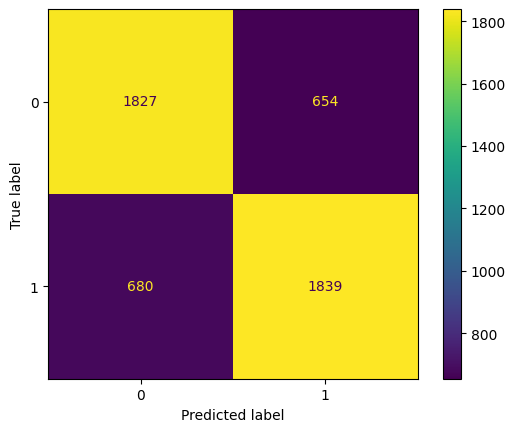

In [46]:
X = df_copy['sentiment_score'].values.reshape(-1, 1)
y = df_copy['sentiment']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
preds = log_reg.predict(X_test)
ConfusionMatrixDisplay.from_estimator(log_reg, X_test, y_test)

In [48]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.73      0.74      0.73      2481
           1       0.74      0.73      0.73      2519

    accuracy                           0.73      5000
   macro avg       0.73      0.73      0.73      5000
weighted avg       0.73      0.73      0.73      5000

